In [1]:
!pip install datasets peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
from datasets import load_dataset
import torch
from transformers import RobertaForTokenClassification, RobertaTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, TaskType
import os
from transformers import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt

In [50]:
class CustomRoBERTaDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, labels, max_length):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

In [51]:
DATA_PATH = "/content/drive/MyDrive/data"
BATCH_SIZE = 32
LR = 1e-3
NUM_EPOCHS = 20
MAX_LENGTH = 32

In [52]:
# Check if a GPU is available and set the device accordingly

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [53]:
# Load the pretrained RoBERTa model and tokenizer

model_name = "distilroberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForTokenClassification.from_pretrained(model_name, num_labels=2)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
# Move model parameters to gpu if available

model.to(device)

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Lay

In [55]:
# Configure LoRA

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,    # Task type: sequence classification
    inference_mode=False,          # Set to False for training
    r=8,                           # Rank for the LoRA matrices
    lora_alpha=16,                 # Scaling factor
    lora_dropout=0.5,              # Dropout probability
    target_modules="all-linear"
)

In [56]:
# Apply the LoRA configuration to the model

model = get_peft_model(model, lora_config)

In [57]:
test_dataset = torch.load(os.path.join(DATA_PATH, "processed_test_dataset.pt"))
train_dataset = torch.load(os.path.join(DATA_PATH, "processed_train_dataset.pt"))

<ipython-input-57-005ab9aa3587>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_dataset = torch.load(os.path.join(DATA_PATH, "processed_test_dataset.pt"))
<ipython-inp

In [58]:
test_dataload = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False)
train_dataload = torch.utils.data.DataLoader(dataset=train_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True)

In [59]:
# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=LR)
loss_f = torch.nn.CrossEntropyLoss(weight=torch.Tensor([1, 30]).to(torch.float64).to(device))

history_loss = []

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()  # Set the model to training mode
    total_loss = 0

    for batch in tqdm(train_dataload):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device).to(torch.int64)

        # Forward pass
        outputs = model(input_ids=input_ids).logits.to(torch.float64)
        loss = loss_f(outputs.view(-1, 2), labels.view(-1))
        total_loss += loss.item()
        history_loss.append(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataload)

    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}, Average Loss: {avg_loss:.4f}")

100%|██████████| 96/96 [00:07<00:00, 12.69it/s]



Epoch 1/20, Average Loss: 0.4968


100%|██████████| 96/96 [00:08<00:00, 10.72it/s]



Epoch 2/20, Average Loss: 0.4359


100%|██████████| 96/96 [00:07<00:00, 13.10it/s]



Epoch 3/20, Average Loss: 0.3867


100%|██████████| 96/96 [00:07<00:00, 13.25it/s]



Epoch 4/20, Average Loss: 0.3668


100%|██████████| 96/96 [00:07<00:00, 13.31it/s]



Epoch 5/20, Average Loss: 0.3542


100%|██████████| 96/96 [00:07<00:00, 13.40it/s]



Epoch 6/20, Average Loss: 0.3437


100%|██████████| 96/96 [00:07<00:00, 13.48it/s]



Epoch 7/20, Average Loss: 0.3358


100%|██████████| 96/96 [00:07<00:00, 13.45it/s]



Epoch 8/20, Average Loss: 0.3272


100%|██████████| 96/96 [00:07<00:00, 13.40it/s]



Epoch 9/20, Average Loss: 0.3265


100%|██████████| 96/96 [00:07<00:00, 13.23it/s]



Epoch 10/20, Average Loss: 0.3175


100%|██████████| 96/96 [00:07<00:00, 13.21it/s]



Epoch 11/20, Average Loss: 0.3052


100%|██████████| 96/96 [00:07<00:00, 12.68it/s]



Epoch 12/20, Average Loss: 0.3101


100%|██████████| 96/96 [00:07<00:00, 12.57it/s]



Epoch 13/20, Average Loss: 0.3100


100%|██████████| 96/96 [00:07<00:00, 13.27it/s]



Epoch 14/20, Average Loss: 0.3040


100%|██████████| 96/96 [00:07<00:00, 13.26it/s]



Epoch 15/20, Average Loss: 0.3044


100%|██████████| 96/96 [00:07<00:00, 13.41it/s]



Epoch 16/20, Average Loss: 0.3124


100%|██████████| 96/96 [00:08<00:00, 10.80it/s]



Epoch 17/20, Average Loss: 0.2902


100%|██████████| 96/96 [00:07<00:00, 13.36it/s]



Epoch 18/20, Average Loss: 0.2903


100%|██████████| 96/96 [00:07<00:00, 13.28it/s]



Epoch 19/20, Average Loss: 0.2959


100%|██████████| 96/96 [00:07<00:00, 13.32it/s]


Epoch 20/20, Average Loss: 0.2769


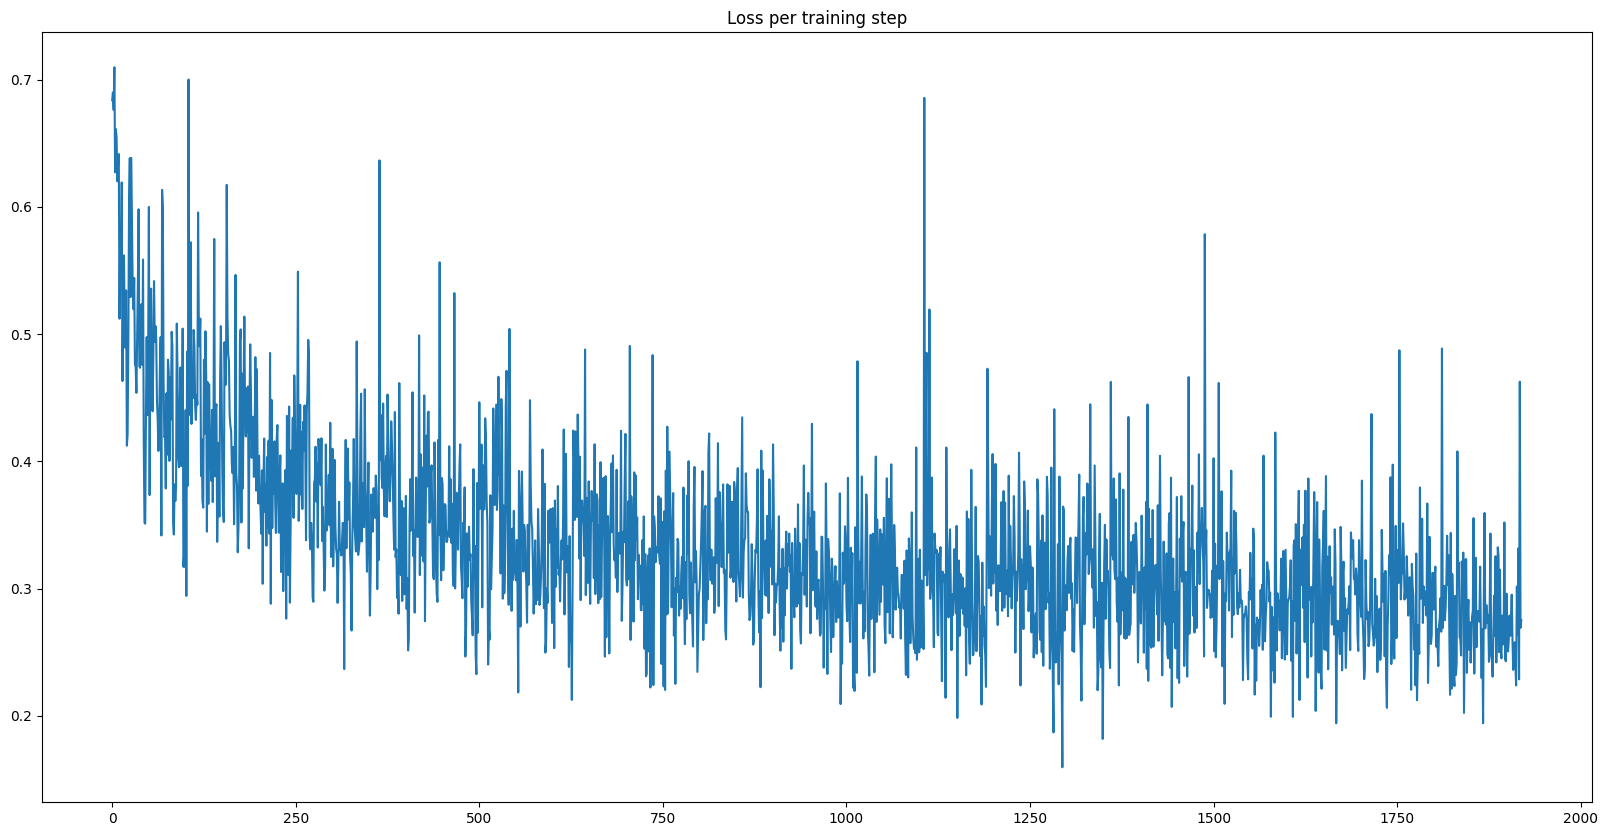

In [60]:
plt.figure(figsize=(20, 10))

plt.plot(history_loss)
plt.title("Loss per training step")
plt.show()

In [61]:
def acc(model, dataloader):
    model.eval()

    total_acc = 0

    for batch in iter(dataloader):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device).to(torch.int64)

        with torch.inference_mode():
            outputs = model(input_ids=input_ids)

        outputs = torch.softmax(outputs.logits, dim=2).argmax(dim=2)
        acc = (outputs == labels).to(float).mean()
        total_acc += acc

    total_acc /= len(dataloader)
    return total_acc

In [62]:
acc(model, train_dataload)

tensor(0.8124, device='cuda:0', dtype=torch.float64)

In [63]:
acc(model, test_dataload)

tensor(0.8054, device='cuda:0', dtype=torch.float64)

In [64]:
def avg_pos_true(model, dataloader):
    model.eval()

    total_pos_true = 0

    for batch in iter(dataloader):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device).to(torch.int64)

        with torch.inference_mode():
            outputs = model(input_ids=input_ids)

        outputs = torch.softmax(outputs.logits, dim=2).argmax(dim=2)[labels.bool()]
        pos_true = (outputs == 1).to(float).mean()
        total_pos_true += pos_true

    total_pos_true /= len(dataloader)
    return total_pos_true

In [65]:
avg_pos_true(model, train_dataload)

tensor(0.9961, device='cuda:0', dtype=torch.float64)

In [66]:
avg_pos_true(model, test_dataload)

tensor(0.9275, device='cuda:0', dtype=torch.float64)

In [67]:
torch.save(model, os.path.join(DATA_PATH, "roberta_fine_tuned.pt"))